In [5]:
%run "All_helper_classes.ipynb" sort=False

#from "Models training helpers.ipynb" we will import 3 helper classes and the associated helper methods.
parsing_helpers = generic_parsing_helpers()
aivm_helper = AIVM_helper()
model_helpers, info = default_model_helpers_for_project()
#if you want to see the paths now can call with...
# # display (HTML(info))

paths = project_paths()

#same for paths and repo data, display using...
# display (HTML(paths.get_paths_data()))
# display (HTML(paths.get_repo_data()))

Necessary libraries imported.
Initialised generic_parsing_helpers class and methods
Initialised AIVM_helper class and methods
Initialised model_helpers class and methods


In [6]:
%%javascript
//To remove scroll from any output area and automatically extend the jupyter cell
IPython.OutputArea.prototype._should_scroll = function(lines) {
    return false;}

<IPython.core.display.Javascript object>

# First we will retrieve the most recently trained DL Models, Calibration Models and the Threshold.
these have been stored in the "Resource" directory of Git as a pickle file.
        * global_final_thresholds.pickle
        * {conv}_models.pickle
        * {conv}_calibration_model.pickle


In [8]:
#Read the latest models/Tresholds etc from GIT "Resource" directory.
USE_GIT_HUB = True


AI_GITHUB = "Data/ToBeAnalyzed/github_AI_repos_dump.csv"
REDDIT_AI = "Data/ToBeAnalyzed/reddit_data_all.csv"
SS  = "Data/ToBeAnalyzed/s2_sents_ki_ids_23k.tsv"
# NON_AI_GITHUB = "Data/ToBeAnalyzed/github_non_AI_repos_dump.csv"
# SEM_SCHOLAR = ""


AI_GITHUB_GIT = "https://github.com/aideenf/AIVC/blob/master/cp_wssc/Data/ToBeAnalyzed/github_AI_repos_dump.csv?raw=true"
REDDIT_AI_GIT = "https://github.com/aideenf/AIVC/blob/master/cp_wssc/Data/ToBeAnalyzed/reddit_data_all.csv?raw=true"
SS_GIT = "https://github.com/aideenf/AIVC/blob/master/cp_wssc/Data/ToBeAnalyzed/s2_sents_ki_ids_23k.tsv?raw=true"

# NON_AI_GITHUB_GIT = "Data/ToBeAnalyzed/github_non_AI_repos_dump.csv"
# SEM_SCHOLAR_GIT = ""


_DLModelsIsotonicRegression = {}
_DLModels = {}
_thresholds = {}
_tokenizer = ""

_thresholds = model_helpers.read_thresholds_from_pickle(USE_GIT_HUB)
display(_thresholds)

_DLModels = model_helpers.read_models_from_pickle(USE_GIT_HUB, _thresholds )
display(_DLModels)

_DLModelsIsotonicRegression = model_helpers.read_calibration_models_from_pickle(USE_GIT_HUB, _thresholds)
display(_DLModelsIsotonicRegression)

_tokenizer = model_helpers.read_tokenizer_from_pickle(USE_GIT_HUB)
display (_tokenizer)

Reading from GIT: global_final_thresholds.pickle?raw=true


{'civic': 0.5,
 'domestic': 0.5,
 'green': 0.5,
 'industrial': 0.5,
 'inspired': 0.5,
 'market': 0.5,
 'project': 0.5,
 'renown': 0.5}

Reading from GIT: civic_models.pickle?raw=true
Reading from GIT: domestic_models.pickle?raw=true
Reading from GIT: green_models.pickle?raw=true
Reading from GIT: industrial_models.pickle?raw=true
Reading from GIT: inspired_models.pickle?raw=true
Reading from GIT: market_models.pickle?raw=true
Reading from GIT: project_models.pickle?raw=true
Reading from GIT: renown_models.pickle?raw=true


{'civic': {'model': <keras.engine.training.Model at 0x1425897f0>},
 'domestic': {'model': <keras.engine.training.Model at 0x14ad7bf98>},
 'green': {'model': <keras.engine.training.Model at 0x14ad83240>},
 'industrial': {'model': <keras.engine.training.Model at 0x11bf76d68>},
 'inspired': {'model': <keras.engine.training.Model at 0x142622400>},
 'market': {'model': <keras.engine.training.Model at 0x142628c88>},
 'project': {'model': <keras.engine.training.Model at 0x14a8f00b8>},
 'renown': {'model': <keras.engine.training.Model at 0x11bfee7f0>}}

Reading from GIT: civiccalibration_model.pickle?raw=true
Reading from GIT: domesticcalibration_model.pickle?raw=true
Reading from GIT: greencalibration_model.pickle?raw=true
Reading from GIT: industrialcalibration_model.pickle?raw=true
Reading from GIT: inspiredcalibration_model.pickle?raw=true
Reading from GIT: marketcalibration_model.pickle?raw=true
Reading from GIT: projectcalibration_model.pickle?raw=true
Reading from GIT: renowncalibration_model.pickle?raw=true


{'civic': {'model': IsotonicRegression(increasing=True, out_of_bounds='clip', y_max=None,
                     y_min=None)},
 'domestic': {'model': IsotonicRegression(increasing=True, out_of_bounds='clip', y_max=None,
                     y_min=None)},
 'green': {'model': IsotonicRegression(increasing=True, out_of_bounds='clip', y_max=None,
                     y_min=None)},
 'industrial': {'model': IsotonicRegression(increasing=True, out_of_bounds='clip', y_max=None,
                     y_min=None)},
 'inspired': {'model': IsotonicRegression(increasing=True, out_of_bounds='clip', y_max=None,
                     y_min=None)},
 'market': {'model': IsotonicRegression(increasing=True, out_of_bounds='clip', y_max=None,
                     y_min=None)},
 'project': {'model': IsotonicRegression(increasing=True, out_of_bounds='clip', y_max=None,
                     y_min=None)},
 'renown': {'model': IsotonicRegression(increasing=True, out_of_bounds='clip', y_max=None,
                    

Reading from GIT: extended_tokenizer.pickle?raw=true


{'tokenizer': <keras_preprocessing.text.Tokenizer at 0x1424c32b0>}

In [25]:
# This method will use the trained classification and calibration models to predict and quantify 
# the presence of conventions in new data(the data to be analyzed)
 
def predict_scores_and_classify(thresholds_in, to_predict_df, _tokenizer, _DLModels, _DLModelsIsotonicRegression, seq_len):
    
    predict = True
     
    extended_tokenizer = _tokenizer
 
    
    #Replacing R_BODY in the cases with reddit body defined.
    sequences = extended_tokenizer.texts_to_sequences(to_predict_df.copy()['text'].str.replace('R_BODY', ''))
    data = pad_sequences(sequences, maxlen= seq_len) 
    extended_tokenizer = 0
    sequences = 0
    gc.collect()
    

    
    thresholds = {'civic': 0.5,
                  'domestic': 0.5,
                  'green': 0.5,
                  'industrial': 0.5,
                  'inspired': 0.5,
                  'market': 0.5,
                  'project': 0.5,
                  'renown': 0.5}
    # otherwise use default.
    
    if thresholds_in != None:
        thresholds = thresholds_in
       
    column_list = []
    column_list.append("repo_id")
    column_list.append("text")
    column_list.append("repo")
    
    for conv in _DLModels.keys():
        column_list.append(conv)
        column_list.append(conv+"_prob")
        column_list.append(conv+"_y_pred")
        column_list.append(conv+"_prob_1")
        
    df = pd.DataFrame(columns=column_list)
    all_df = pd.DataFrame(columns=column_list)
    
    ###################
    #a sub function within the function, just used in this scope 
    def sub_funct_get_prob(prob, y):
        res = []
        for (probability, predicted) in zip(prob, y):
            if predicted == 1:
                res.append(probability)
            if predicted == 0:
                res.append(1 - probability)
        return res
    ####################

    df = pd.DataFrame(columns=column_list)
    
    #get the the txt of the sentence to be Analyzed
    df['text'] = to_predict_df["text"]
    df['repo_id'] = to_predict_df["repo_id"]
    df['repo'] = to_predict_df["repo"]

        

    for model in _DLModels.keys():
        my_model = _DLModels[model]           
        #First through the model
        y_predict = my_model['model'].predict(data)
                
        #get the score for value = 1 as the response is [x,y] we need only the y values
        y_pos_predict_prob = model_helpers.get_positive_preds_probabilities(y_predict)
                
        #get the 1 or 0 value depending on the threshold
        y_pred = model_helpers.get_positive_preds_with_threshold(y_pos_predict_prob, thresholds[model])
                
        #if the call has been made with an isotonic reg calibration model too then call its predict.
        if _DLModelsIsotonicRegression != None:
            other_ir = _DLModelsIsotonicRegression[model]
            y_pos_predict_isotonic_prob = other_ir['model'].predict(y_pos_predict_prob)
            y_pred = model_helpers.get_positive_preds_with_threshold(y_pos_predict_isotonic_prob, thresholds[model])
            y_pos_predict_prob = y_pos_predict_isotonic_prob
                
        #The probability of the y_predict, whether it i 1 or 0
        df[model+"_prob"] =  sub_funct_get_prob(y_pos_predict_prob, y_pred)
        df[model+"_y_pred"] = y_pred
        df[model+"_prob_1"] = y_pos_predict_prob         
        
   
    y_pred_list = []
    for x in df.columns.values:
        if x.endswith(('_y_pred')):
            y_pred_list.append(x)
            
    prob_list = []
    conv_list = []
    for x in df.columns.values:
        if x.endswith(('_prob')):
            prob_list.append(x)
            conv_list.append(x.replace('_prob', ''))
    
    if predict == True:
        #add the label cardinality as the sum of all the predicted = 1 for sentence for conventions
        pred_sums = df[y_pred_list].sum(axis=1)
        df['lbl_cnt'] = pred_sums
        #add the overall score as the product of all the individual predicted convention scores
        prob_product= all_df[prob_list].prod(axis=1)
        df['set_conf'] = prob_product
    
    
    #this will be > 1 if the same sentence was used as True for 2 or more conventions.
    positive_sample = df[conv_list].sum(axis=1)
    df['pos_sample'] = positive_sample
     
    print ("Num Dupes:", len(df.index) - len(df['text'].unique()) )

    #now we are droppping the dupes but we should not. 
    df = df.drop_duplicates(keep = "first")
    
    co_occur_list = []
    rename = []
    for x in df.columns.values:
            if x.endswith(('_y_pred')):
                co_occur_list.append(x)
                rename.append(x.replace('_y_pred', ''))

    co_occur_y_predict = df[co_occur_list].copy()
    for old, x in zip(co_occur_list, range(len(co_occur_list))): 
        co_occur_y_predict = co_occur_y_predict.rename(columns={old: rename[x]})
        
    plt.figure(figsize=(10,5))
    plt.style.use('seaborn-dark-palette')
        
    text = "Predicted Co-occurance Matrix with Predicted and Actual Cardinality "
    display (HTML("<font color = green><h3><left>" + text + "</left></h3></font>"))
    ax1 = plt.subplot(1, 2, 1)
    ax1 = model_helpers.co_occurance_matrix (co_occur_y_predict)

    ax2 = plt.subplot(1, 2, 2)
    ax2 = model_helpers.label_cardinality_bar(co_occur_y_predict, title = "Predicted Cardinality") 
    plt.show()   
    return df.fillna(0), thresholds


def clean_descriptions (text, keep_case, remove_tab_line):
    
    # remove any line starting with a tab and ending with a space or new line.
    if remove_tab_line == True:
        text = re.sub(r'\\t.*?\\n', ' ', text)
        text = re.sub(r'\\t.*?\\s', ' ', text)
        
    
    try:
        #remove snippets of code
        text = re.sub("```.*?```", " ", text)
    except: 
        print ("WOOOOPS:", text)
    
    #https://regex101.com/r/cO8lqs/2
    text = re.sub("b'", ' ', text)
    
    text = re.sub("i\.e\.", 'i.e', text)
    text = re.sub("e\.g\.", 'e.g', text)
    
    # remove anything with this format "[![text]...."
    text = re.sub(r'\[\!.*?\)', ' ', text)
    
        
    # remove anything with this format "([.....))."
    text = re.sub(r'\(\[.*?\)\)\.', ' ', text)
    
    
    # remove anything with this format "([.....))"
    text = re.sub(r'\(\[.*?\)\)', ' ', text)
    
    
    # remove headers and replace with full stop, in case a previous sentence doed not have it
    text = re.sub(r'\#.*?\n', ' ', text)
    
    #remove HTML tags
    text = re.sub("(<.*?>)","",text)
    
    #remove URL's
    text = re.sub(r'\(http[s]?://(?:[a-zA-Z]|[0-9]|[$-_@.&+]|[!*\(\),]|(?:%[0-9a-fA-F][0-9a-fA-F]))+', '', text, flags=re.MULTILINE)
    text = re.sub(r'http[s]?://(?:[a-zA-Z]|[0-9]|[$-_@.&+]|[!*\(\),]|(?:%[0-9a-fA-F][0-9a-fA-F]))+', '', text, flags=re.MULTILINE)

    #remove new lines as they are not correctly formatted
    text = text.replace('\\n', " ")
    text = text.replace('\n', " ")


    #r
    text = text.replace("\\'", "'")
    text = text.replace("\'", "'")
    
    # remove anything with this format "[![text]"
    text = re.sub(r'\[\!.*?\]', ' ', text)
    
    
    #remove tables
    text = re.sub(r"[\|].*?[\|]", "||", text)
    
    text = re.sub(r"[^a-zA-Z0-9.,\'-|]",' ', text)    
    text = text.replace("[", "")
    text = text.replace("]", "")
    text = text.replace("--", "")
    text = text.replace(" -", "")
    text = text.replace("- ", "")
    text = re.sub(' +', ' ', text)
   
    new_list = []
    text_list = text.split('||')
    for line in text_list:
        if len(line) > 25:
            new_list.append(line +'\n')
    text = ''   
    text = text.join(new_list)
    text = text.replace("*", "")
    text = text.replace("\\n", ".")
    text = text.replace("\n", ".")

    text = text.replace(" .", ".")
    text = text.replace("..", ".")
    text = text.lstrip()
    text = text.rstrip()
    text = text.strip()
    
    text = re.sub(r"[\\][x][0-9][0-9][0-9]", "", text)
    text = re.sub(r"[\\][x][a-z][0-9]", "", text)
    text = re.sub(r"[\\][x][a-z][a-z]", "", text)
    text = re.sub(r"[\\][x][0-9][0-9]", "", text)
    text = re.sub(r"[\\][x][a-z]", "", text)
    text = re.sub(r"[\\][x][0-9]", "", text)
    text = re.sub(r"[\\][x]", " ", text)
    text_list = text.split('. ')
    new_list = []
    for line in text_list:
        
        line = line.strip()
        if keep_case == False:
            line = line.capitalize() + '.\n'
        else:
            line = line + '.\n'
        new_list.append(line)
    text = ''   
    text = text.join(new_list)
    
    text = re.sub('\.__', ' ', text)
    text = re.sub('__\.', ' ', text)
    text = re.sub('__' ,'', text)
    text = re.sub('>_' ,'', text)
    text = re.sub('/' ,' ', text)
    text = re.sub('{' ,'', text)
    text = re.sub('Image::' ,'', text)
    text = re.sub(r"=","",text)
    text = re.sub(r'\r',"",text)
    text = re.sub(r'\\r',"",text)
    text = re.sub(r"\(\)","",text)
    text = text.replace(" .", ".")
    text = text.replace("..", ".")
    text = text.replace(">", "")
    text = text.replace(":height:", "")
    text = text.replace(".. image::", "")
    text = text.replace(":target:", "")
    text = text.replace(":alt:", "")
    text = text.replace("`_", "`")
    text = text.replace("^", "")
    text = text.replace("Code-block::", "")
    text = text.replace(":start-offset", "")
    text = text.replace(":end-offset", "")
    text = text.replace("\\\\", "\\")
    text = text.replace("\t", " ")
    text = text.replace("\r", " ")
    text = text.replace("image::", " ")

    text = re.sub(' +', ' ', text)
    
    return text


def create_pd_from_repo(_texts, _id, _name, _keep_case, _remove_tab_line ):
    # for every repo in the _texts file, 
    # get the raw description
    # process it
    # convert to an array of sentences
    # add each individual sentence to a pandas
    # add the repo ID to the pandas.  in the end we will 
    # have a pandas DB with repo_id and text to be predicted.
    # only add the text if it is more than 40 letters long
    print ("num repos", len ( _texts))
    print ("num id's", len ( _id))
    
 
    def my_fun(variable):
        if variable == 'R_BODY R_BODY.':
            return False
        if len(variable) > 6:
            return True
        else:
            if 'R_BODY.' in variable:
                 #print (variable)
                return True
        return False
    
    
    df_all = pd.DataFrame()
    for x in range(len(_texts)):
        df = pd.DataFrame()
        sent = _texts[x]
        repo_id = _id[x]
        repo_name = _name[x]
        sen_arr = clean_descriptions(sent, _keep_case, _remove_tab_line).split("\n")
        sen_arr  = list(filter(my_fun, sen_arr)) 
            
        df['text'] = sen_arr
        df['repo_id'] = repo_id
        df['repo'] = repo_name
        
        #remove very short sentences and empty BODY
        df_all = pd.concat([df_all, df])
    print ("full list length",df_all.shape[0] )
    return df_all

def analyze_git_repo(url, thresholds, tokenizer, DLModels, DLModelsIsotonicRegression, model_helpers):
    AI_repos = pd.read_csv(url, sep=";")
    
    AI_texts = AI_repos['repo_raw_description'].values
    AI_repo_id = AI_repos['repo_id'].values
    AI_repo_name = AI_repos['repo_name'].values
    AI_repos = 0
    gc.collect()
    res, _ = predict_scores_and_classify(thresholds, create_pd_from_repo(AI_texts, AI_repo_id, AI_repo_name, False, True ), tokenizer, DLModels, DLModelsIsotonicRegression, model_helpers.MAX_SEQUENCE_LENGTH)
    AI_repos = 0
    AI_texts = 0
    AI_repo_id = 0

    text = "Probabilistic count v's Classification count"
    display (HTML("<font color = green><h4><left>" + text + "</left></h4></font>"))
    display (model_helpers.get_count(res, _DLModels, thresholds, num_prob_buckets = 8, actual=False ))
    return res


def tag_sentence_text (df, thresholds ):
    # Append a sequence of tags to the end of each classified sentence
    # e.g. Tensorflow is an end-to-end open source platform for machine learning.[0,0,0,1,0,0,0,0,] 
    # This will be used to show which tags match which sentence during analysis 
    # (after re-grouping sentences by RepoId or subredit id etc.
    sum_list = []
    prob_1_list = []
    for conv in thresholds:
        sum_list.append(conv+'_y_pred')
        prob_1_list.append(conv+'_prob_1')

            
    df['text'] = df['text'] + '['
    for conv_pred in sum_list :
        df['text'] = df["text"].map(str) +  df[conv_pred].map(str) +','
    df['text'] = df['text'] + "]"
    
    df['text'] = df['text'] + '['
    for prob in prob_1_list :
        df['text'] = df["text"].map(str) +  round (df[prob],2).map(str) +','
    df['text'] = df['text'] + "]."
    return df


def re_group(df, convention_dict):
    sum_list = []
    for conv in convention_dict:
        sum_list.append(conv+'_y_pred')
    sum_list.append("text")
    grouped_df = df.groupby(['repo_id', 'repo'])
    grouped_df = grouped_df[sum_list].sum(axis=0)

    def applyFunc(s): 
        return len(s.split(' '))
    def numSen(s): 
        return len(s.split('].'))

    grouped_df['word_count'] = grouped_df['text'].apply(applyFunc)
    grouped_df['sentence_count'] = grouped_df['text'].apply(numSen)


    print ("The number of repos is", grouped_df.shape[0])
    grouped_df = grouped_df.reset_index()
    grouped_df['word_count'] = grouped_df['text'].apply(applyFunc)
    return grouped_df



def print_analysis(df, file_path, to_display, number, source):
    
    f1=open(file_path, 'w+')

    i = 0

    for x in range(number):
        
        i = x + 1
        html = ""
        
        if to_display == True:
            print("****************************EXAMPLE ",i, "************************************")
            print("Number of words:", df.iloc[i][11])
            print("Number of sentences:", df.iloc[i][12])
            print("Total civic:", df.iloc[i][2])
            print("Total domestic:", df.iloc[i][3])
            print("Total green:", df.iloc[i][4])
            print("Total industrial:", df.iloc[i][5])
            print("Total inspired:", df.iloc[i][6])
            print("Total market:", df.iloc[i][7])
            print("Total project:", df.iloc[i][8])
            print("Total renown:", df.iloc[i][9])
            if source == "github":
                print("URL:", 'https://github.com/' + df.iloc[i][1] + '/blob/master/README.md')
                print("URL:", 'https://github.com/' + df.iloc[i][1] + '/blob/master/README.rst')
                print ("Reference:" , df.iloc[i][0])
            if source == "reddit":
                print("URL:",  df.iloc[i][1] )
                print ("Reference:", df.iloc[i][0])
            if source == "ss":
                print("URL:",  df.iloc[i][1] )
                print ("Reference:", df.iloc[i][0])


        f1.write("<br/>****************************EXAMPLE " + str(i) + "************************************")
        f1.write("<br/>Number of words:"+ str( df.iloc[i][11]))
        f1.write("<br/>Number of sentences:"+ str( df.iloc[i][12]))
        f1.write("<br/>Total civic:"+ str(df.iloc[i][2]))
        f1.write("<br/>Total domestic:"+ str(df.iloc[i][3]))
        f1.write("<br/>Total green:"+ str(df.iloc[i][4]))
        f1.write("<br/>Total industrial:"+ str(df.iloc[i][5]))
        f1.write("<br/>Total inspired:"+ str(df.iloc[i][6]))
        f1.write("<br/>Total market:"+ str(df.iloc[i][7]))
        f1.write("<br/>Total project:"+ str(df.iloc[i][8]))
        f1.write("<br/>Total renown:"+ str(df.iloc[i][9]))
        
        if source == "github":
            f1.write("<br/><a href='https://github.com/" 
                     + df.iloc[i][1] 
                     + "/blob/master/README.md'>https://github.com/" 
                     + df.iloc[i][1] 
                     + "/blob/master/README.md</a>")
    
            f1.write("<br/><a href='https://github.com/" 
                     + df.iloc[i][1] 
                     + "/blob/master/README.rst'>https://github.com/" 
                     + df.iloc[i][1] 
                     + "/blob/master/README.rst</a>")
        
        if source == "reddit":
            f1.write("<br/><a href='" 
                     + df.iloc[i][1] 
                     + "'>" 
                     + df.iloc[i][1] 
                     + "</a>")
            
        if source == "ss":
            f1.write("<br/><a href='" 
                     + df.iloc[i][1] 
                     + "'>" 
                     + df.iloc[i][1] 
                     + "</a>")
        
        f1.write("<br/>Reference:"+ str(df.iloc[i][0]))
        
        sen_arr = df.iloc[i][10].split("].")
        
        if to_display == True:
            print("")

        title = ''
        get_title = False
        for sen in sen_arr:
            try:
               
                parts = sen.split("[")
                tags = parts[1].split(",")
                prob = parts[2].split(",")
                del tags[-1]
                del prob[-1]

                tags = list(map(int, tags))
                prob = list(map(float,  prob))

                sum_list = []
                count = 0
                conventions = ""
                for conv, x in zip(_thresholds, range(len(tags)) ):
                    if conv == "industrial":
                        color = 'red'
                    if conv == "civic":
                        color = 'blue'
                    if conv == "domestic":
                        color = 'purple'  
                    if conv == "market":
                        color = 'violet'  
                    if conv == "project":
                        color = 'orange' 
                    if conv == "green":
                        color = 'green'  
                    add_text = "<font color=" + color + ">" + conv + ':' + str(prob[x]) + ', ' + "</font>"
                    if tags[x] == 1:
                        conventions =  conventions + add_text  + " "
                        count = count + 1
               
                
                text_a = ''
                text_b = ''
                
                if get_title == True:

                    if (count > 0):
                        conventions = conventions[:-10]+"</font>"
                        title = '<br/><b>Title:</b><br/>' + parts[0][:-1] + "</b>" + "[" + conventions + "]" + '<b>. </b><br/><br/>'
                    else:
                        title = '<br/><b>Title:</b><br/>' + parts[0] + '<br/><br/>'
                    get_title = False   
                
                if 'R_BODY.' in parts[0]:
         
                    parts[0] = parts[0].replace('R_BODY.', '')
                    text_b = '<br/><br/><b>Comments:</b><br/>'
                    get_title = True #A hack because of the way i collected the data. the title is the first sentence in the comment field
                     
                if 'R_BODY' in parts[0]:
                
                    parts[0] = parts[0].replace('R_BODY', '')
                    text_a = '<b>Body:</b> <br/>'
            
                if (count > 0):
                    conventions = conventions[:-10]+"</font>"
                    html = html + " " + text_a + "<b>" + parts[0][:-1] + "</b>" + "[" + conventions + "]" + '<b>. </b>' + text_b
                    
                else:
                    html = html +  " " + text_a + parts[0] + text_b 

            except:
                continue
        if source == "reddit":
            if title == '':
                html_list = html.split('. ')
                title =  '<br/><b>Title:</b><br/>'+html_list[0] +'<br/><br/><b>Comments:</b><br/>'
                html_list.pop(0)
                html = '. '.join(html_list)
            else:
                html_list = html.split('Comments:</b><br/>')
                html_list_reduced = html_list[1].split('. ')
                html_list_reduced.pop(0)
                html_list[1] = '. '.join(html_list_reduced)
                html = 'Comments:</b><br/>'.join(html_list)
             
                
        
        html = title + html
        
        
        if to_display == True:        
            display(HTML(html))
            
        f1.write("<br/>")
        f1.write("<br/>")
        f1.write( html)
        f1.write("<br/>")
        f1.write("<br/>")
        
        if to_display == True:
            print("")
            print("")
            print("")
    print ("File saved")
    f1.close()
    
def scatter_plot(grouped_df):
    from pandas.plotting import scatter_matrix
    plt.style.use('ggplot')
    sm = scatter_matrix(grouped_df.rename(columns={
    "civic_y_pred": "civic",
    "domestic_y_pred": "domestic",
    "green_y_pred": "green",
    "industrial_y_pred": "industry",
    "inspired_y_pred": "inspired",
    "market_y_pred": "market",
    "project_y_pred": "project",
    "renown_y_pred": "renown",
    "word_count": "words",
    }).drop("text", axis = 1),figsize=[20,20], alpha=0.4, diagonal='kde')
    #kernel density estimation(KDE)
    plt.show()
    
    
    
def analyze_subreddit(url, thresholds, tokenizer, DLModels, DLModelsIsotonicRegression, model_helpers, min_score):
    reddit_df = pd.read_csv(url)
    reddit_df.loc[reddit_df['body'] == "[deleted]", 'body'] = " "
    reddit_df.loc[reddit_df['body'] == "[removed]", 'body'] = " "
    reddit_df.loc[reddit_df['body'].isnull(), 'body'] = " "
    reddit_df = reddit_df.loc[reddit_df['score'] > min_score] 
    reddit_df =  reddit_df.reset_index()
    reddit_df['url'] = "https://www.reddit.com/r/artificial/comments/" + reddit_df['id']
  
    reddit_df['text'] = "R_BODY " + reddit_df['body'] + "R_BODY. " + reddit_df['comments']
    reddit_df.dropna(inplace=True)

    texts = reddit_df['text'].values
    subreddit_id = reddit_df['id'].values
    url = reddit_df['url'].values
    
    reddit_df = reddit_df.drop("created", axis = 1).drop("score", axis = 1).drop("title", axis = 1).drop("comments", axis = 1).drop("body", axis = 1)
    print (reddit_df.shape[0])
    print (len(reddit_df.id.unique()))
    
    del reddit_df
    gc.collect()
    res, _ = predict_scores_and_classify(thresholds, create_pd_from_repo(texts, subreddit_id, url, True, False ), tokenizer, DLModels, DLModelsIsotonicRegression, model_helpers.MAX_SEQUENCE_LENGTH)
    del texts
    del subreddit_id
    del url
    text = "Probabilistic count v's Classification count"
    display (HTML("<font color = green><h4><left>" + text + "</left></h4></font>"))
    display (model_helpers.get_count(res, _DLModels, thresholds, num_prob_buckets = 8, actual=False ))
    return res


def analyze_ss(url, thresholds, tokenizer, DLModels, DLModelsIsotonicRegression, model_helpers):
    ss_df = pd.read_csv(url, sep = '\t', names=["repo_id", "text"])
    

    ss_df.dropna(inplace=True)
    ss_df.text.apply(lambda x: clean_descriptions(x,True,False))
    ss_df['repo'] = "http://api.semanticscholar.org/"  + ss_df.repo_id
    print (ss_df.shape[0])
    gc.collect()
    res, _ = predict_scores_and_classify(thresholds, ss_df, tokenizer, DLModels, DLModelsIsotonicRegression, model_helpers.MAX_SEQUENCE_LENGTH)
    del ss_df
    text = "Probabilistic count v's Classification count"
    display (HTML("<font color = green><h4><left>" + text + "</left></h4></font>"))
    display (model_helpers.get_count(res, _DLModels, thresholds, num_prob_buckets = 8, actual=False ))
    return res

# Classify GitHub AI repo with latest models

    _DLModelsIsotonicRegression 
    _DLModels
    _thresholds
    _tokenizer

In [10]:
#Can use this to test the clean_descriptions function for github
# AI_repos = pd.read_csv(AI_GITHUB_GIT, sep=";")
# row = AI_repos.loc[AI_repos['repo_id'] == 3964514] 
# display (row)
# display (row.iloc[0][9])
# print (clean_descriptions (row.iloc[0][9], False, True))
# print (clean_descriptions (row.iloc[0][9], False, False))


num repos 8609
num id's 8609
full list length 167437
Num Dupes: 9476


,civic,domestic,green,industrial,inspired,market,project,renown
civic,551.0,5.0,3.0,36.0,1.0,21.0,8.0,3.0
domestic,5.0,238.0,0.0,15.0,9.0,88.0,23.0,0.0
green,3.0,0.0,140.0,9.0,0.0,2.0,0.0,0.0
industrial,36.0,15.0,9.0,93805.0,187.0,1986.0,162.0,1.0
inspired,1.0,9.0,0.0,187.0,396.0,17.0,3.0,0.0
market,21.0,88.0,2.0,1986.0,17.0,4426.0,56.0,1.0
project,8.0,23.0,0.0,162.0,3.0,56.0,476.0,1.0
renown,3.0,0.0,0.0,1.0,0.0,1.0,1.0,22.0


,civic,domestic,green,industrial,inspired,market,project,renown
civic,1.00,0.01,0.0,0.00,0.00,0.00,0.01,0.01
domestic,0.01,1.00,0.0,0.00,0.01,0.02,0.03,0.00
green,0.00,0.00,1.0,0.00,0.00,0.00,0.00,0.00
industrial,0.00,0.00,0.0,1.00,0.00,0.02,0.00,0.00
inspired,0.00,0.01,0.0,0.00,1.00,0.00,0.00,0.00
market,0.00,0.02,0.0,0.02,0.00,1.00,0.01,0.00
project,0.01,0.03,0.0,0.00,0.00,0.01,1.00,0.00
renown,0.01,0.00,0.0,0.00,0.00,0.00,0.00,1.00


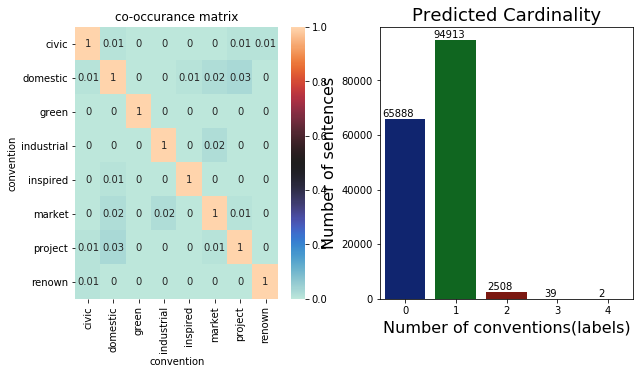

None

<Figure size 432x288 with 0 Axes>

In [21]:
ai_repo_analysis_df = analyze_git_repo(AI_GITHUB_GIT, _thresholds, _tokenizer['tokenizer'], _DLModels, _DLModelsIsotonicRegression, model_helpers)
aivm_helper.save_to_shelf('ai_repo_analysis_df', 'ai_repo_analysis_df', ai_repo_analysis_df, False, None, None)

# Append a tag summary to the end of each sentence. 

- Tensorflow is an end-to-end open source platform for machine learning.[0,0,0,1,0,0,0,0,]
This will be used to show which tags match which sentence during analysis (after re-grouping sentences by RepoId or subredit id etc.


In [22]:
#Reading it from Shelf so we could start at this point if we do not want to classify all data again(if it 
#is already complete), here you will see the 1st line without the tags and then with the tags. 
ai_repo_analysis_df = aivm_helper.retrieve_shelved_object('ai_repo_analysis_df', 'ai_repo_analysis_df', False)
display(ai_repo_analysis_df.iloc[0][1])
display (ai_repo_analysis_df.head(1))
ai_repo_analysis_df = tag_sentence_text(ai_repo_analysis_df, _thresholds )
display("total repos", ai_repo_analysis_df.shape[0])
display(ai_repo_analysis_df.head(1))
display(ai_repo_analysis_df.iloc[0][1])

'Tensorflow is an end-to-end open source platform for machine learning.'

,repo_id,text,repo,civic,civic_prob,civic_y_pred,civic_prob_1,domestic,domestic_prob,domestic_y_pred,...,project_prob,project_y_pred,project_prob_1,renown,renown_prob,renown_y_pred,renown_prob_1,lbl_cnt,set_conf,pos_sample
0,45717250,Tensorflow is an end-to-end open source platfo...,tensorflow/tensorflow,0,0.953488,0,0.046512,0,1.0,0,...,0.833333,0,0.166667,0,0.944444,0,0.055556,1,0.0,0.0


'total repos'

163350

,repo_id,text,repo,civic,civic_prob,civic_y_pred,civic_prob_1,domestic,domestic_prob,domestic_y_pred,...,project_prob,project_y_pred,project_prob_1,renown,renown_prob,renown_y_pred,renown_prob_1,lbl_cnt,set_conf,pos_sample
0,45717250,Tensorflow is an end-to-end open source platfo...,tensorflow/tensorflow,0,0.953488,0,0.046512,0,1.0,0,...,0.833333,0,0.166667,0,0.944444,0,0.055556,1,0.0,0.0


'Tensorflow is an end-to-end open source platform for machine learning.[0,0,0,1,0,0,0,0,][0.05,0.0,0.0,0.85,0.02,0.06,0.17,0.06,].'

# Re-group the sentences based on the Repo_ID

In [23]:
grouped_ai_repo_analysis_df = re_group(ai_repo_analysis_df, _thresholds)
display(grouped_ai_repo_analysis_df.head(2))

aivm_helper.save_to_shelf('grouped_ai_repo_analysis_df', 'grouped_ai_repo_analysis_df', grouped_ai_repo_analysis_df, False, None, None)
aivm_helper.get_all_shelfed('ai_repo_analysis_df', False)
aivm_helper.get_all_shelfed('grouped_ai_repo_analysis_df', False)

The number of repos is 8508


,repo_id,repo,civic_y_pred,domestic_y_pred,green_y_pred,industrial_y_pred,inspired_y_pred,market_y_pred,project_y_pred,renown_y_pred,text,word_count,sentence_count
0,102637,cirg-up/cilib,0,0,0,2,0,0,0,0,Cilib computational intelligence library is a ...,169,5
1,135191,igrigorik/decisiontree,0,0,0,8,0,0,0,0,Decision tree a ruby library which implements ...,186,10


['ai_repo_analysis_df']
['grouped_ai_repo_analysis_df']


# Save a random selection of repos to file for Analysis

In [27]:
print_analysis(grouped_ai_repo_analysis_df, './analysis_GitHub.html', False,100, 'github')

File saved


# Create Scatter plot of re-grouped  AI repos

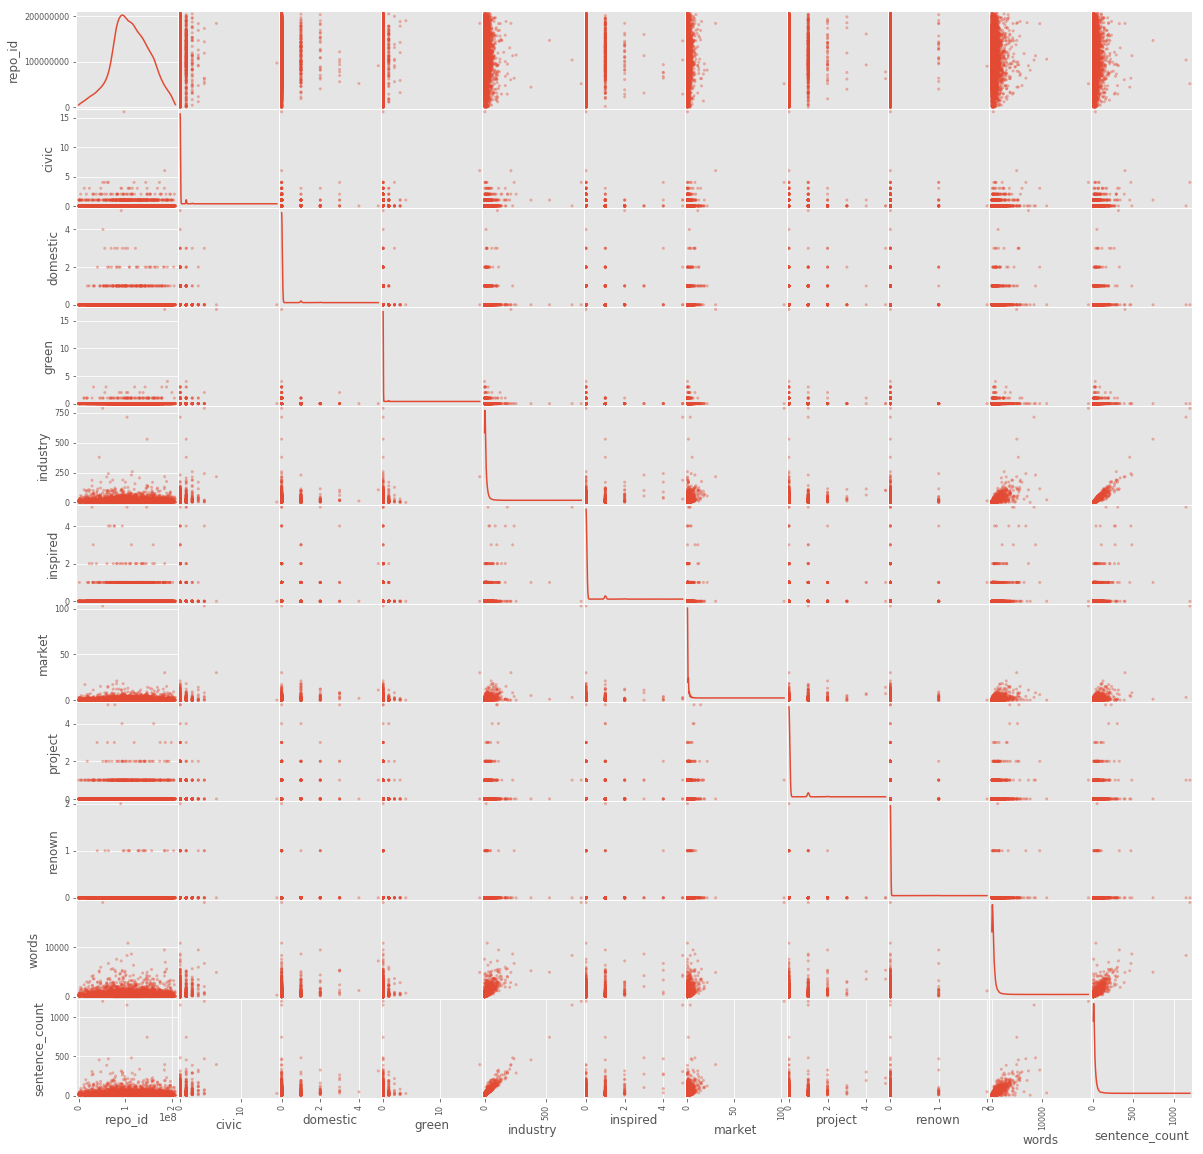

In [28]:
scatter_plot(grouped_ai_repo_analysis_df)

In [29]:
#Release the memory to avoid bursting the notebook!
del ai_repo_analysis_df
del grouped_ai_repo_analysis_df

# Classify Reddit Repo with latest Models

2455
2455
num repos 2455
num id's 2455
full list length 38404
Num Dupes: 557


,civic,domestic,green,industrial,inspired,market,project,renown
civic,398.0,47.0,1.0,1.0,8.0,53.0,17.0,9.0
domestic,47.0,1297.0,0.0,2.0,85.0,380.0,208.0,57.0
green,1.0,0.0,46.0,1.0,0.0,0.0,0.0,0.0
industrial,1.0,2.0,1.0,5324.0,31.0,208.0,15.0,0.0
inspired,8.0,85.0,0.0,31.0,476.0,71.0,10.0,2.0
market,53.0,380.0,0.0,208.0,71.0,2719.0,98.0,16.0
project,17.0,208.0,0.0,15.0,10.0,98.0,844.0,9.0
renown,9.0,57.0,0.0,0.0,2.0,16.0,9.0,151.0


,civic,domestic,green,industrial,inspired,market,project,renown
civic,1.00,0.03,0.0,0.00,0.01,0.02,0.01,0.02
domestic,0.03,1.00,0.0,0.00,0.05,0.09,0.10,0.04
green,0.00,0.00,1.0,0.00,0.00,0.00,0.00,0.00
industrial,0.00,0.00,0.0,1.00,0.01,0.03,0.00,0.00
inspired,0.01,0.05,0.0,0.01,1.00,0.02,0.01,0.00
market,0.02,0.09,0.0,0.03,0.02,1.00,0.03,0.01
project,0.01,0.10,0.0,0.00,0.01,0.03,1.00,0.01
renown,0.02,0.04,0.0,0.00,0.00,0.01,0.01,1.00


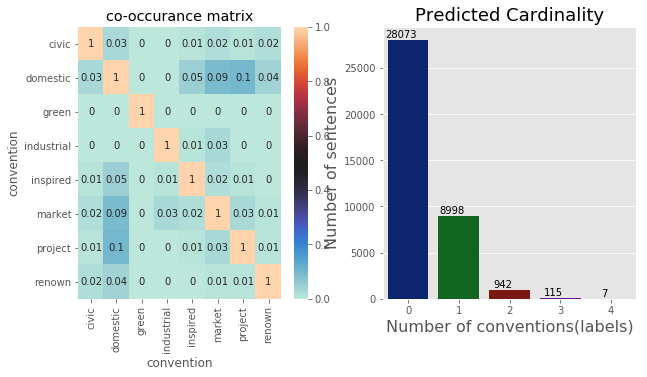

None

<Figure size 432x288 with 0 Axes>

In [30]:
min_score = 4
reddit_analysis_df = analyze_subreddit(REDDIT_AI_GIT,  _thresholds, _tokenizer['tokenizer'], _DLModels, _DLModelsIsotonicRegression, model_helpers, min_score)

# Append a tag summary to the end of each sentence. 

    - Columbia University Team Uses AI, Implants and Speech Synthesizer to Translate Brain Activity Into Words.[0,0,0,1,0,0,0,0,].'

    This will be used to show which tags match which sentence during analysis (after re-grouping sentences by RepoId or subredit id etc.
    

In [31]:
reddit_analysis_df = tag_sentence_text(reddit_analysis_df, _thresholds )
display("total repos", reddit_analysis_df.shape[0])
display(reddit_analysis_df.head(2))
display(reddit_analysis_df.iloc[0][1])

'total repos'

38135

,repo_id,text,repo,civic,civic_prob,civic_y_pred,civic_prob_1,domestic,domestic_prob,domestic_y_pred,...,project_prob,project_y_pred,project_prob_1,renown,renown_prob,renown_y_pred,renown_prob_1,lbl_cnt,set_conf,pos_sample
0,alrasv,"Original video + Stennifer Lawrscemi.[0,0,0,0,...",https://www.reddit.com/r/artificial/comments/a...,0,0.914634,0,0.085366,0,1.0,0,...,0.882353,0,0.117647,0,0.980392,0,0.019608,0,0.0,0.0
1,alrasv,"There's such a sublime juxtaposition here.[0,0...",https://www.reddit.com/r/artificial/comments/a...,0,0.914634,0,0.085366,0,1.0,0,...,0.948276,0,0.051724,0,0.957447,0,0.042553,0,0.0,0.0


'Original video + Stennifer Lawrscemi.[0,0,0,0,0,0,0,0,][0.09,0.0,0.09,0.4,0.17,0.09,0.12,0.02,].'

# Re-group the sentences based on the subredditID

In [32]:
grouped_reddit_analysis_df = re_group(reddit_analysis_df, _thresholds)
display(grouped_reddit_analysis_df.head(2))

#Save the dataframes to local shelf in case want to use them again. 
aivm_helper.save_to_shelf('reddit_analysis_df', 'reddit_analysis_df', reddit_analysis_df, False, None, None)
aivm_helper.save_to_shelf('grouped_reddit_analysis_df', 'grouped_reddit_analysis_df', grouped_reddit_analysis_df, False, None, None)
aivm_helper.get_all_shelfed('reddit_analysis_df', False)
aivm_helper.get_all_shelfed('grouped_reddit_analysis_df', False)

The number of repos is 2455


,repo_id,repo,civic_y_pred,domestic_y_pred,green_y_pred,industrial_y_pred,inspired_y_pred,market_y_pred,project_y_pred,renown_y_pred,text,word_count,sentence_count
0,10jp0x,https://www.reddit.com/r/artificial/comments/1...,0,0,0,6,0,1,2,0,Artificially intelligent game bots pass the Tu...,342,24
1,10kdup,https://www.reddit.com/r/artificial/comments/1...,0,0,0,3,0,0,0,0,Computers match humans in understanding art.[0...,89,11


['reddit_analysis_df']
['grouped_reddit_analysis_df']


# Save some classification results for analysis

In [33]:
print_analysis(grouped_reddit_analysis_df, './reddit_analysis.html', False, 100, "reddit")

File saved


# Create Scatter plot of Subreddit posts

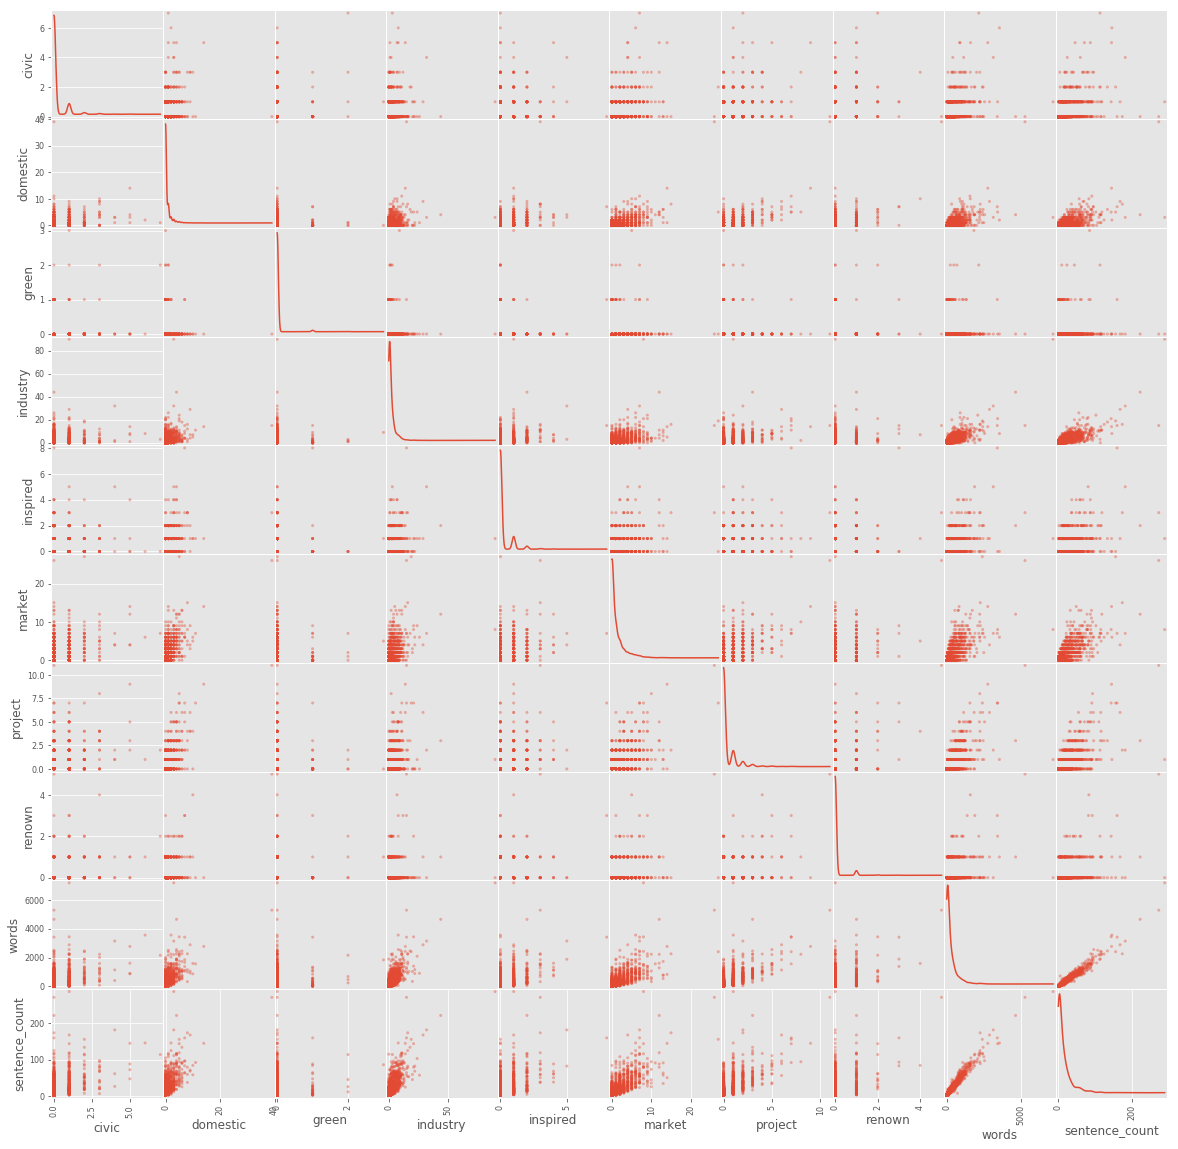

In [34]:
scatter_plot(grouped_reddit_analysis_df)

In [35]:
#delete the dataframes to local shelf to free up some memory
del reddit_analysis_df
del grouped_reddit_analysis_df

# Classify Senmantic Scholar data with latest model

22742
Num Dupes: 85


,civic,domestic,green,industrial,inspired,market,project,renown
civic,21.0,1.0,1.0,0.0,0.0,0.0,0.0,0.0
domestic,1.0,4.0,0.0,0.0,0.0,0.0,0.0,0.0
green,1.0,0.0,22.0,1.0,0.0,0.0,0.0,0.0
industrial,0.0,0.0,1.0,8277.0,25.0,6.0,0.0,0.0
inspired,0.0,0.0,0.0,25.0,88.0,0.0,0.0,0.0
market,0.0,0.0,0.0,6.0,0.0,38.0,0.0,0.0
project,0.0,0.0,0.0,0.0,0.0,0.0,2.0,0.0
renown,0.0,0.0,0.0,0.0,0.0,0.0,0.0,2.0


,civic,domestic,green,industrial,inspired,market,project,renown
civic,1.00,0.04,0.02,0.0,0.0,0.0,0.0,0.0
domestic,0.04,1.00,0.00,0.0,0.0,0.0,0.0,0.0
green,0.02,0.00,1.00,0.0,0.0,0.0,0.0,0.0
industrial,0.00,0.00,0.00,1.0,0.0,0.0,0.0,0.0
inspired,0.00,0.00,0.00,0.0,1.0,0.0,0.0,0.0
market,0.00,0.00,0.00,0.0,0.0,1.0,0.0,0.0
project,0.00,0.00,0.00,0.0,0.0,0.0,1.0,0.0
renown,0.00,0.00,0.00,0.0,0.0,0.0,0.0,1.0


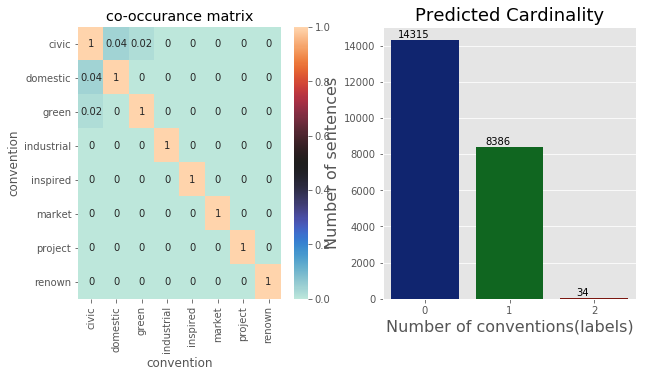

None

<Figure size 432x288 with 0 Axes>

In [36]:

ss_analysis_df = analyze_ss(SS_GIT,  _thresholds, _tokenizer['tokenizer'], _DLModels, _DLModelsIsotonicRegression, model_helpers)  

# Append a tag summary to the end of each sentence. 

    - Columbia University Team Uses AI, Implants and Speech Synthesizer to Translate Brain Activity Into Words.[0,0,0,1,0,0,0,0,].'

    This will be used to show which tags match which sentence during analysis (after re-grouping sentences by RepoId or subredit id etc.
    


In [37]:
ss_analysis_df = tag_sentence_text(ss_analysis_df, _thresholds )
display("total num sentences", ss_analysis_df.shape[0])
display(ss_analysis_df.head(2))
display(ss_analysis_df.iloc[0][1])


'total num sentences'

22735

,repo_id,text,repo,civic,civic_prob,civic_y_pred,civic_prob_1,domestic,domestic_prob,domestic_y_pred,...,project_prob,project_y_pred,project_prob_1,renown,renown_prob,renown_y_pred,renown_prob_1,lbl_cnt,set_conf,pos_sample
0,000ecccdab1f21a0dc977d8fec0e8f2f787281bf,We address the task of recognizing the categor...,http://api.semanticscholar.org/000ecccdab1f21a...,0,0.914634,0,0.085366,0,0.891892,0,...,1.000000,0,0.000000,0,0.930233,0,0.069767,0,0.0,0.0
1,000ecccdab1f21a0dc977d8fec0e8f2f787281bf,This task is challenging because of the need t...,http://api.semanticscholar.org/000ecccdab1f21a...,0,0.953488,0,0.046512,0,1.000000,0,...,0.882353,0,0.117647,0,0.941214,0,0.058786,0,0.0,0.0


'We address the task of recognizing the category of an ongoing human action from a video stream.[0,0,0,0,0,0,0,0,][0.09,0.11,0.26,0.31,0.17,0.04,0.0,0.07,].'

# Re-group the sentences based on the abstract id

In [38]:
grouped_ss_analysis_df = re_group(ss_analysis_df, _thresholds)
display(grouped_ss_analysis_df.head(2))


The number of repos is 2950


,repo_id,repo,civic_y_pred,domestic_y_pred,green_y_pred,industrial_y_pred,inspired_y_pred,market_y_pred,project_y_pred,renown_y_pred,text,word_count,sentence_count
0,000ecccdab1f21a0dc977d8fec0e8f2f787281bf,http://api.semanticscholar.org/000ecccdab1f21a...,0,0,0,1,0,0,0,0,We address the task of recognizing the categor...,177,9
1,0017542f2f908b0f2ce3558ca1767687b1db42bb,http://api.semanticscholar.org/0017542f2f908b0...,0,0,0,5,0,0,0,0,Navigation systems have been widely used in ou...,195,12


# print out some samples for analysis

In [40]:
print_analysis(grouped_ss_analysis_df, './s2_analysis.html', False, 100, "ss")

File saved


In [ ]:
scatter_plot(grouped_ss_analysis_df)

In [ ]:
#Save the dataframes to local shelf in case want to use them again. 
aivm_helper.save_to_shelf('ss_analysis_df', 'ss_analysis_df', ss_analysis_df, False, None, None)
aivm_helper.save_to_shelf('grouped_ss_analysis_df', 'grouped_ss_analysis_df', grouped_ss_analysis_df, False, None, None)
aivm_helper.get_all_shelfed('ss_analysis_df', False)
aivm_helper.get_all_shelfed('grouped_ss_analysis_df', False)

In [ ]:

class Take(BaseEstimator, TransformerMixin):
    """Pass through a single column without modification"""
    def __init__(self, col):
        self.col = col
        
    def fit(self, X, y=None):
        return self
    
    def transform(self, X, y=None):
        return X[self.col].to_frame(self.col)
name = ai_repo_analysis_df.index
print (name [0])


features = [
    ('civic_y_pred', Take('civic_y_pred')),
    ('domestic_y_pred', Take('domestic_y_pred')),
    ('green_y_pred', Take('green_y_pred')),
    ('industrial_y_pred', Take('industrial_y_pred')),
    ('inspired_y_pred', Take('inspired_y_pred')),
    ('market_y_pred', Take('market_y_pred')),
    ('project_y_pred', Take('project_y_pred')),
    ('renown_y_pred', Take('renown_y_pred')),
    ('word_count', Take('word_count')),
]
pipe = Pipeline([
    ('feat', FeatureUnion(features)),
    ('scale', StandardScaler())
])

trans = pipe.fit_transform(grouped_ai_repo_analysis_df)


# Try to cluster using KMeans for colouring out plot
cluster = KMeans(n_clusters=8)
group_pred = cluster.fit_predict(trans)

# Perform t-SNE to reduce the dimensionality down to 2 dimenions, for easier plotting.
tsne = TSNE(n_components=2)
tsne_fit = tsne.fit_transform(trans)

init_notebook_mode(connected=True)

trace = go.Scatter(
    x=tsne_fit.T[0], 
    y=tsne_fit.T[1],
    mode='markers',
    name='Lines, Markers and Text',
    text=name,
    textposition='top left',
    marker=dict(
        color = group_pred, #set color equal to a variable
        colorscale='Portland',
        showscale=True
    )
)

data = [trace]
layout = go.Layout(
    showlegend=False
)
fig = go.Figure(data=data, layout=layout)
iplot(fig)

# View a sample repo and it's convention for manual analysis

In [ ]:
num  = 180
display(grouped_ai_repo_analysis_df[num:num+1])
display(grouped_ai_repo_analysis_df.iloc[num][8] )

# Search for repos with > or < x words

In [ ]:
sum_list_new = sum_list
sum_list_new.pop()
repos = grouped_ai_repo_analysis_df.loc[grouped_ai_repo_analysis_df['word_count'] > 10000 ]
display(repos.head(3) )
display(repos.shape[0] )
#display(green_repos.iloc[2][8] )
display (repos.iloc[0][8])